In [1]:
import warnings
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
os.environ['DGLBACKEND'] = 'pytorch'
from ogb.nodeproppred import DglNodePropPredDataset, Evaluator
import pandas as pd
from plotly import express as px
from plotly import graph_objects as go
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from data import DataModule
from models import GCN, GAT
%matplotlib inline


torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore")

def compute_acc(pred, labels, evaluator):
    return evaluator.eval(
        {"y_pred": pred.argmax(dim=-1, keepdim=True), "y_true": labels}
    )["acc"]


def compute_accuracy_train_val_test(pred, labels, idx, split_idx):
    return {
        f"{stage}_acc": compute_acc(
            pred[split_idx[stage]],
            labels[split_idx[stage]],
            evaluator=Evaluator(name="ogbn-arxiv"),
        )
        for stage in ["train", "valid", "test"]
    }

fig = go.FigureWidget(px.line(pd.DataFrame({'train': [0], 'valid': [0], 'test': [0]}), range_x=[0, 100]))

def update_figure(trainer, _):
    for line in fig.data:
        line.y = np.append(line.y, trainer.callback_metrics[f'{line.legendgroup}_acc'].cpu())
        line.x = np.append(line.x, trainer.current_epoch)

In [2]:
data = DglNodePropPredDataset("ogbn-arxiv")
graph, labels = data[0]
split_idx = data.get_idx_split()
n_classes = data.num_classes
datamodule = DataModule(
    use_labels=True,
    split_idx=split_idx,
    labels=labels,
    graph=graph,
    n_classes=n_classes,
)

Graph with 175 nodes and 1023 edges


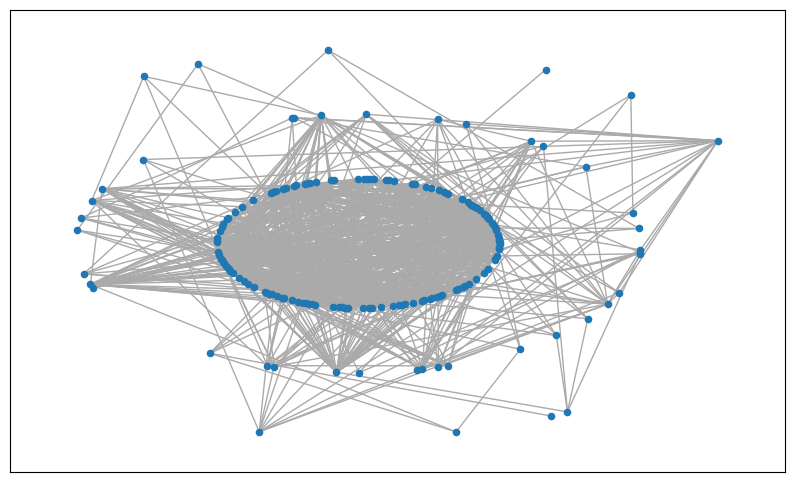

In [3]:
n_rows, n_cols = 1, 1
max_hops = 3
max_outer_nodes = 10
fig = plt.subplots(n_rows, n_cols, figsize=(10, 6))[0]
source_id = 0
G = graph.to_networkx()
path_lengths = np.array(list(nx.single_source_shortest_path_length(
    G.to_undirected(), source_id, cutoff=max_hops).items()))
subgraph = nx.Graph(nx.induced_subgraph(G, path_lengths[:, 0]))
path_lengths_outer = path_lengths[path_lengths[:, 1] == path_lengths[:, 1].max()]
np.random.shuffle(path_lengths)
subgraph.add_edges_from([(target_id, 999) for target_id in path_lengths_outer[:max_outer_nodes, 0]])
paths = nx.all_shortest_paths(subgraph, source_id, 999)
node_ids = list(set(sum([path[:-1] for path in paths if source_id in path], [])))
shells = [[] for _ in range(path_lengths[:, 1].max() + 1)]
for node_id, path_length in path_lengths:
    shells[path_length].append(node_id)
subgraph = nx.Graph(nx.induced_subgraph(G, node_ids))
print(subgraph)
subgraph.remove_node(source_id)
nx.draw_networkx(
    subgraph,
    nx.shell_layout(subgraph, shells),
    ax=fig.axes[0],
    with_labels=False,
    node_size=20,
    edge_color='#aaaaaa'
)

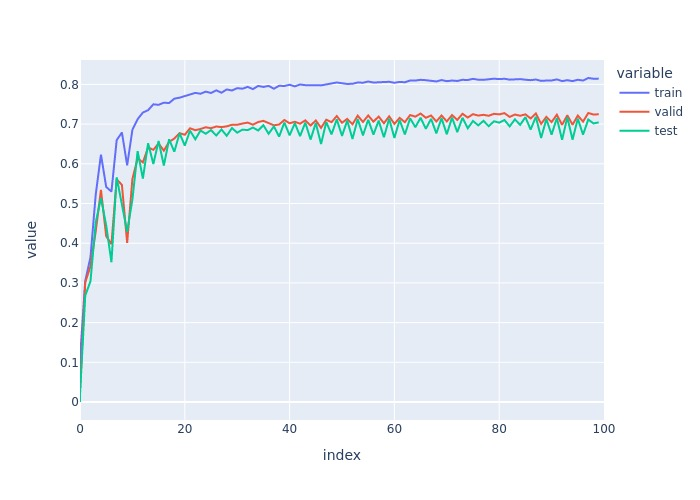

In [8]:
accuracy = lambda pred, labels, idx: compute_accuracy_train_val_test(
    pred, labels, idx, split_idx
)

model = GCN(
    in_feats=graph.ndata["feat"].shape[1] + n_classes,
    n_classes=n_classes,
    n_hidden=256,
    n_layers=3,
    activation=F.relu,
    dropout=0.75,
    use_linear=False,
    val_metric=accuracy,
)
fig

In [7]:
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=100,
    callbacks=[pl.callbacks.LambdaCallback(
        on_train_epoch_end=update_figure
    )],
    enable_progress_bar=False,
)
trainer.fit(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | convs    | ModuleList | 118 K 
1 | bns      | ModuleList | 1.0 K 
2 | dropout0 | Dropout    | 0     
3 | dropout  | Dropout    | 0     
----------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.479     Total estimated model params size (MB)


Total edges after adding self-loop 2501829


`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
n_epochs = 100
n_layers = 3
n_hidden = 256
n_heads = 3
dropout = 0.75
attn_drop = 0.05
norm = "none"  # "both"

model = GAT(
    graph.ndata["feat"].shape[1] + n_classes,
    n_classes,
    n_hidden=n_hidden,
    n_layers=n_layers,
    n_heads=n_heads,
    activation=F.relu,
    dropout=dropout,
    attn_drop=attn_drop,
    norm=norm,
    val_metric=accuracy,
)

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=100,
    log_every_n_steps=1,
)
trainer.fit(model, datamodule=datamodule)